# Creating the Initial Conditions


First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
import cmocean.cm as cm
import cartopy.crs as ccrs
from scipy.interpolate import griddata



Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [2]:
# define the input directory
input_dir = 'C:\\Users\\Daniel\\Desktop\\185C_Project'

## Constructing the Initial Conditions
For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the initial condition fields in 7 steps:
1. download 4 fields generated by the ECCO model
2. read the ECCO model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, I donwloaded the following list of files that contain the field pertaining to starting point of my model (January 2008):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_2016.nc|
|SALT|SALT/SALT_2016.nc|
|UVEL|UVEL/UVELMASS_2016.nc|
|VVEL|VVEL/VVELMASS_2016.nc|
|ETAN|ETHAN/ETAN_2016.nc|

I stored these fields in the following directory:

In [3]:
data_folder = 'C:\\Users\\Daniel\\Desktop\\185C_Project\\Data'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, I will rely on the `grid` module from the `eccoseas.ecco` package, which I import here:

In [4]:
import sys
sys.path.insert(1,'C:\\Users\\Daniel\\Desktop\\185C_Project\\eccoseas')
from eccoseas.ecco import grid

In [5]:
ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(os.path.join(data_folder,'nctiles_grid','GRID'), var_name='XC')
ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(os.path.join(data_folder,'nctiles_grid','GRID'), var_name='YC')
ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(os.path.join(data_folder,'nctiles_grid','GRID'), var_name='hFacC')
ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(os.path.join(data_folder,'nctiles_grid','GRID'), var_name='RF')

The ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to my region, I'll read in my model grid next.

### Step 3: Read in the Model Grid
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [6]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/16
xgOrigin = -175
ygOrigin = 75
n_rows = 360
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'CA_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [7]:
from eccoseas.downscale import hFac

In [ ]:
depth = bathy
RF_tiles = ecco_RF_tiles
delR = RF_tiles[1]*-1
hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [9]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

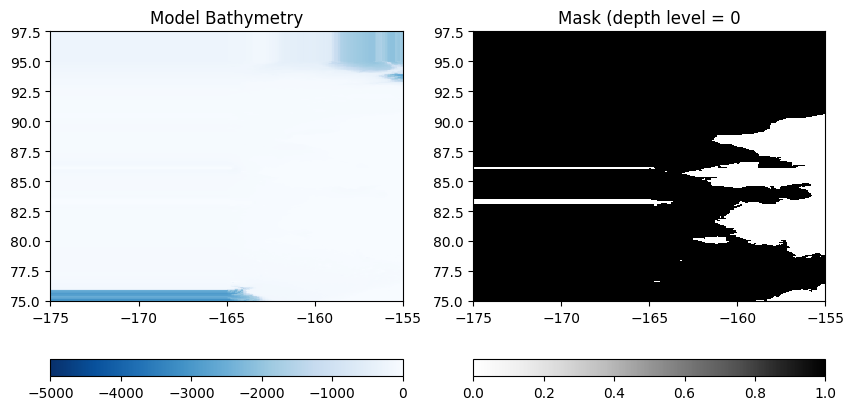

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[depth_level], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. After some trial and error (and referencing THIS page), I find that tiles 8 and 11 have the points I need:

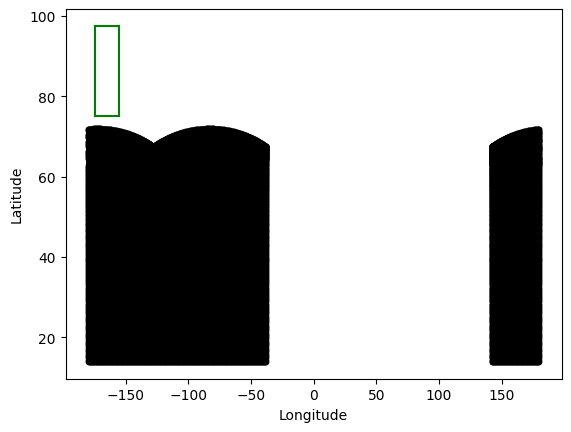

In [11]:
# plot the ECCO tile poitns from tiles 8 and 11
plt.plot(ecco_XC_tiles[11],ecco_YC_tiles[11],'k.')
plt.plot(ecco_XC_tiles[8],ecco_YC_tiles[8],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
tile_list = [8,11]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(RF_tiles[1]) , total_points))
ecco_mask_points = np.zeros((np.size(RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(RF_tiles[tile_number])):
        level_hFac = ecco_hFacC_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFac)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFac.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_mask_points = ecco_mask_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [13]:
# make a file dictionary to loop over
file_prefix_dict = {'ETAN':'ETAN_2016.nc'}
variable_names = list(file_prefix_dict.keys())

Now, read the initial condition fields from the same tiles:

In [14]:
# make a list to hold all of the ECCO grids
init_grids = []

# # loop through each variable to read in the grid
for variable_name in variable_names:
    ds = nc4.Dataset(os.path.join(data_folder,'nctiles_monthly',variable_name,variable_name+'_2016.nc'))
    grid = ds.variables[variable_name][:,:,:,:]
    time = ds.variables['time'][:]
    tile = ds.variables['tile'][:]
    ds.close()

    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN':
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((np.size(RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name == 'ETAN':
            init_grid[0,points_counted:points_counted+N] = \
                 grid[0, tile_number-1, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    init_grid = init_grid[:,local_indices]
    init_grids.append(init_grid)

### Step 5: Interpolate the Fields onto the Model Grid
Next, I will interpolate the ECCO external fields I read in onto my model domain. I will use the `horizonal` module from the `eccoseas` package to accomplish this interpolation.

In [15]:
from eccoseas.downscale import horizontal

#### &#x2757; Warning
This code block may take a while to run. Further, it will generate 4 files sized ~500MB. Plan accordingly.

In [19]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    # print a message to keep track of which variable we are working on
    # uncomment to use
    # print('    - Interpolating the '+variable_name+' grid')

    if variable_name == 'ETAN':
        model_mask = mask[:1,:,:]
    else:
        model_mask = mask

    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points.ravel(), ecco_YC_points.ravel()]),
                                                                  init_grid, ecco_mask_points, 
                                                                  XC, YC, model_mask)


    # output the interpolated grid
    output_file = os.path.join(input_dir,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)

### Step 6: Plotting the External Forcing Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [20]:
meta_dict = {'ETAN':[0, 1, 'viridis', 'm']}

Then, I'll create all of the subplots:

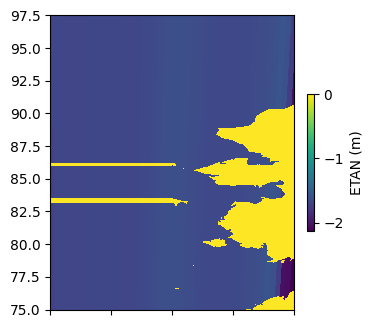

In [21]:
fig = plt.figure(figsize=(8,10))
gs = GridSpec(3, 2, wspace=0.4, hspace=0.03, 
              left=0.11, right=0.9, top=0.95, bottom=0.05)


for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    CA_init_grid = np.fromfile(os.path.join(input_dir,variable_name+'_IC.bin'),'>f4')

    if variable_name == 'ETAN':
        CA_init_grid = CA_init_grid.reshape((np.shape(XC)[0], np.shape(XC)[1]))
    else:
        CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1]))
        CA_init_grid = CA_init_grid[0, :, :] # choose just the surface for plotting
    
    ax1 = fig.add_subplot(gs[i])
    C = plt.pcolormesh(XC, YC, CA_init_grid,
                       # vmin=meta_dict[variable_names[i]][0],
                       # vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
    plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.026)

    if i<5:
        plt.gca().set_xticklabels([])
    else:
        plt.gca().set_xlabel('Longitude')
    if i%2==1:
        plt.gca().set_yticklabels([])
    if i==7:
        plt.gca().axis('off')
    if i==2:
        plt.gca().set_ylabel('Latitude')

plt.show()

### Step 7: Run-time considerations
To use the grids as initial conditions in the model, I will specify them as "hydrography" conditions. Specifically, I will add the following lines to `PARM05` of the data file:

```
hydrogTheta = 'THETA_IC.bin',
hydrogSalt = 'SALT_IC.bin',
uVelInitFile = 'UVEL_IC.bin',
vVelInitFile = 'VVEL_IC.bin',
pSurfInitFile = 'ETAN_IC.bin',
```